# Smart Parking & Dynamic Pricing: Optimizing Urban Mobility and Revenue

The Smart Parking & Dynamic Pricing system leverages data-driven insights to optimize parking availability, reduce congestion, and enhance revenue generation. By analyzing daily parking meter revenue, the impact of discounted parking rates for electric vehicles or residents, and the usage of promotional codes for commuters, cities can develop adaptive pricing strategies that balance demand and accessibility. This approach helps urban planners implement real-time pricing models, incentivize off-peak parking, and encourage sustainable mobility solutions. The goal of this analysis is to predict future daily revenue integrating historical data and predictive analytics, smart parking systems can dynamically adjust prices based on traffic flow, special events, and occupancy rates, ultimately creating a more efficient and sustainable urban environment.

# Useful Functions

In [1]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = mean_squared_error(test, predictions, squared = False)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

In [2]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

# Libraries and Data

In [3]:
!pip install pmdarima

   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   --------------------------------------- 625.1/625.1 kB 11.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------------------------------- -- 2.6/2.8 MB 12.5 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 11.6 MB/s eta 0:00:00


In [21]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima, ARIMA, model_selection
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings('ignore')

In [14]:
# Loading the daily revenue data and set the date as uindex
df = pd.read_csv("daily_parking.csv",
                 index_col = "date",
                 parse_dates = True,
                 dayfirst = True)
df.head()

,parking_revenue,discount_rate,commuter_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [15]:
# Information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   parking_revenue  1795 non-null   object
 1   discount_rate    1795 non-null   object
 2   commuter_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


In [16]:
# Remove the comma in revenue and convert it as float
df['parking_revenue'] = df['parking_revenue'].str.replace(",", "").astype(float)

In [17]:
# Set the dataframe to have daily frequency
df = df.asfreq("D")

In [18]:
# Change the time Series variable name
df = df.rename(columns = {'parking_revenue': 'y'})
df.head()

,y,discount_rate,commuter_rate
date,,,
2018-01-01,6270839.0,34.27%,1.09%
2018-01-02,8922076.0,30.87%,1.08%
2018-01-03,8446101.0,28.11%,1.01%
2018-01-04,7785798.0,27.32%,0.96%
2018-01-05,6375303.0,25.70%,0.90%


A list of commonly used `.asfreq()` aliases:

Time-based frequencies:

- 'D': Calendar day frequency
- 'B': Business day frequency
- 'W': Weekly frequency
- 'W-MON', 'W-TUE', ..., 'W-SUN': Weekly frequency (anchored on a specific day)
- 'M': Month end frequency
- 'MS': Month start frequency
- 'Q': Quarter end frequency
- 'QS': Quarter start frequency
- 'A' or 'Y': Year end frequency
- 'BA' or 'BY': Business year end frequency
- 'AS' or 'YS': Year start frequency
- 'BAS' or 'BYS': Business year start frequency


Hourly, minutely, and secondly frequencies:

- 'H': Hourly frequency
- 'T' or 'min': Minutely frequency
- 'S': Secondly frequency


You can also use multiples, like:

- '2D': Every 2 days
- '4H': Every 4 hours
- '15T' or '15min': Every 15 minutes

# Exploratory Data Analysis

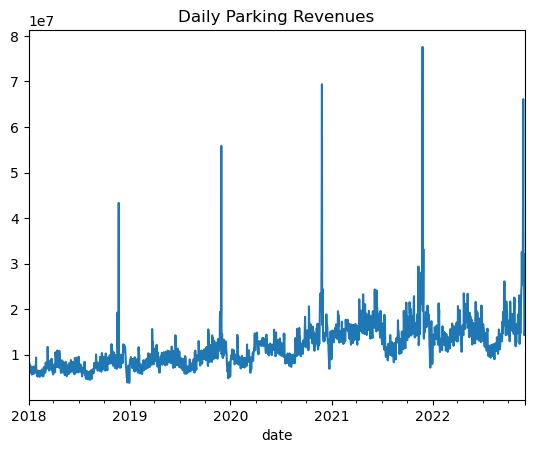

In [19]:
# Daily revenues line plot
df['y'].plot(title = 'Daily Parking Revenues')
plt.show()

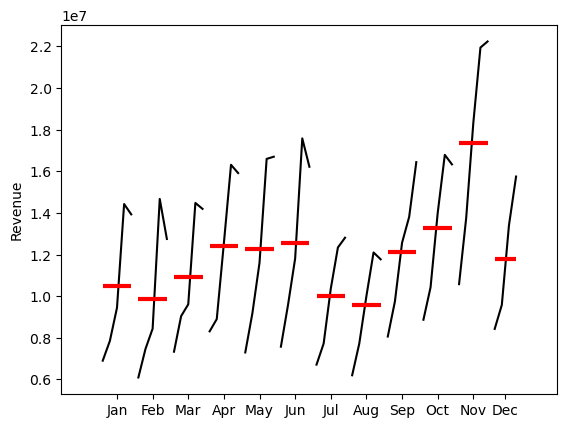

In [22]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of revenue values
month_plot(df['y'].resample('M').mean(),
           ylabel = 'Revenue')
plt.show()

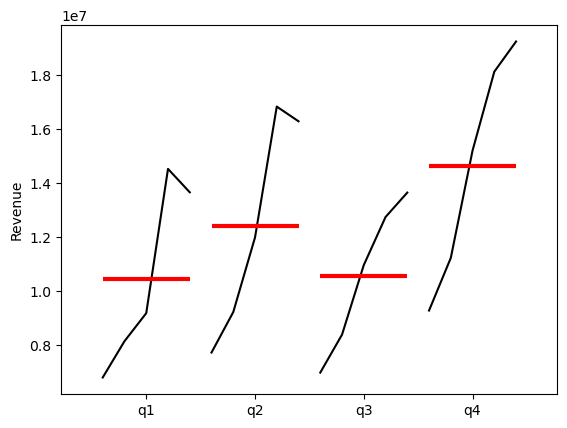

In [23]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of revenue values
# .resample('Q') - to convert the time series data into quarterly seasonality
quarter_plot(df['y'].resample('Q').mean(),
           ylabel = 'Revenue')
plt.show()

`seasonal_decompose` - To decompose a time series into its constituent parts to better understand the underlying patterns.

components

- Trend: The overall direction of the series (increasing, decreasing, or stable).
- Seasonal: Repeating patterns at fixed intervals (e.g., daily, weekly, monthly).
- Residual: The remaining variation after removing trend and seasonal components.

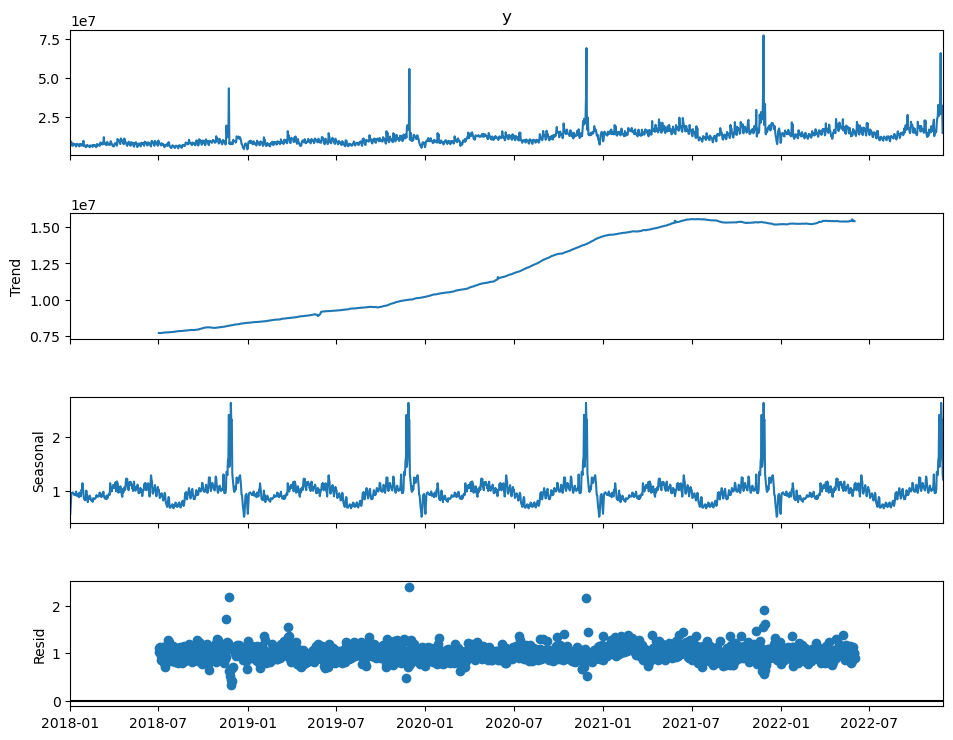

In [24]:
# Seasonal Decomposition Plots for Revenue Data
# Multiplicative model type, with daily seasonality (365 days)
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.


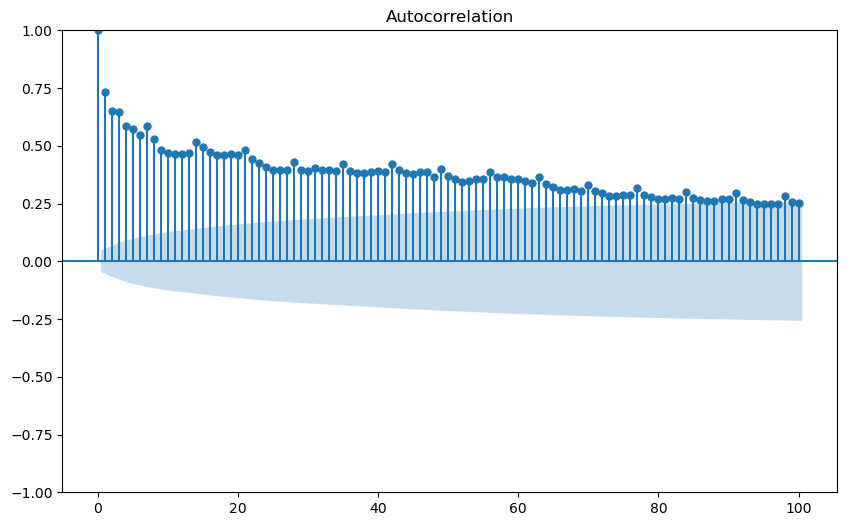

In [25]:
# Plot the autocorrelation (ACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100, ax = ax)
plt.show()

PACF measures the correlation between a time series and its lag, after removing the effects of all shorter lags.

Purpose: To identify the direct relationship between an observation and its lag, without intermediate effects.

Main Difference between ACF and PACF:
- ACF: Measures overall correlation at each lag, including indirect effects.
- PACF: Measures direct correlation at each lag, excluding indirect effects.

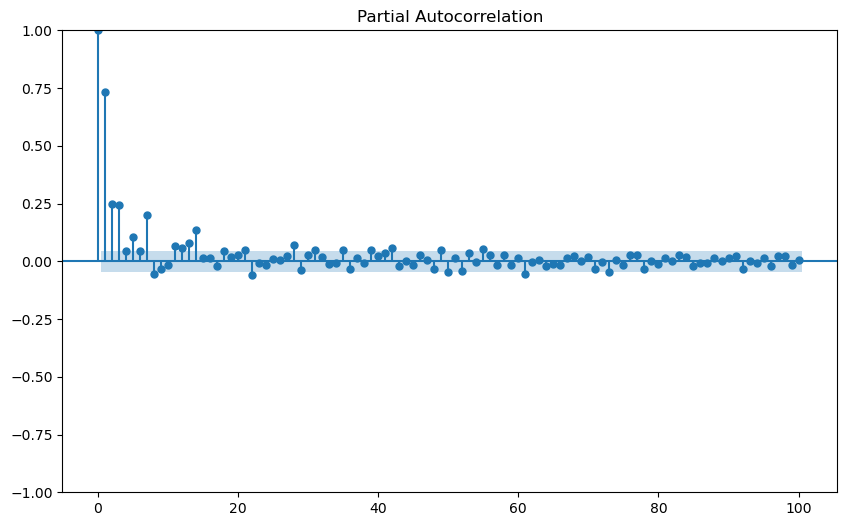

In [26]:
# Plot the partial autocorrelation (PACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()

`.resample()` offset aliases:
- B = business day
- D = calendar day
- W = weekly
- M = month end
- BM = business month end
- MS = month start
- BMS = business month start
- Q = quarter end
- BQ = business quarter end
- QS = quarter start
- BQS = business quarter start
- A = year end
- BA = business year end
- AS = year start
- BAS = business year start
- h = hourly
- min = minutely
- s = secondly
- ms = milliseconds
- us = microseconds

# Stationarity

`adfuller` - used to perform the Augmented Dickey-Fuller test, which is a statistical test for testing the stationarity of a time series

 Stationarity implies that the statistical properties of the time series, such as mean and variance, do not change over time.

 The test evaluates a null hypothesis that the time series is non-stationary. If the p-value obtained from the test is less than a significance level (commonly 0.05), we reject the null hypothesis and conclude that the time series is stationary.

In [27]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
# 'result' contains the test statistic and the p-value.
result = adfuller(df.y)
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")


p-value: 0.101904
Evidence suggests that the time series is not stationary.


In [28]:
# Compute the first difference of the 'y' column in DataFrame 'df' and assign it to a new column 'y_diff'.
# '.diff()' calculates the difference between consecutive elements along the specified axis (by default axis 0).
# 'dropna()' removes any rows with NaN values resulting from differencing.
df['y_diff'] = df.y.diff().dropna()
df['y_diff']

date
2018-01-01           NaN
2018-01-02     2651237.0
2018-01-03     -475975.0
2018-01-04     -660303.0
2018-01-05    -1410495.0
                 ...    
2022-11-26   -39180777.0
2022-11-27     4955921.0
2022-11-28      210050.0
2022-11-29   -17786305.0
2022-11-30      712049.0
Freq: D, Name: y_diff, Length: 1795, dtype: float64

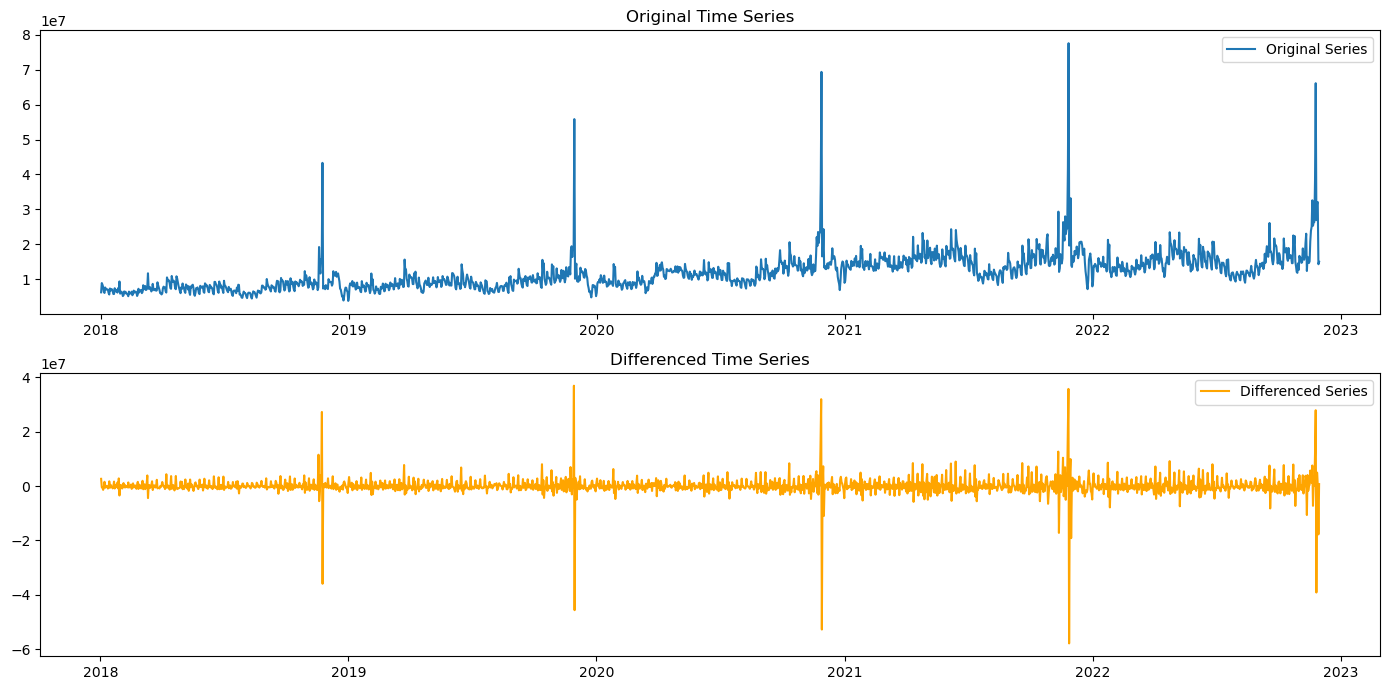

In [29]:
# Plotting the original and differenced series
# Set the size of the plot to 14 inches by 7 inches
plt.figure(figsize=(14, 7))

# Subplot for the original series
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(df.y, label='Original Series')
plt.title('Original Time Series')
plt.legend()

# Subplot for the differenced series
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(df['y_diff'], label='Differenced Series', color='orange')
plt.title('Differenced Time Series')
plt.legend()

# Adjust layout to prevent overlapping of titles and labels
plt.tight_layout()
plt.show()

In [30]:
# Perform ADF test without null values
# 'result' contains the test statistic and the p-value.
result = adfuller(df['y_diff'].dropna())
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

p-value: 0.000000
Evidence suggests that the time series is stationary.


# ARIMA Model

In [31]:
# Split the Data into training and test
test_days = 30 # Number of days to reserve for testing
train, test = df.iloc[:-test_days], df.iloc[-test_days:]
test

,y,discount_rate,commuter_rate,y_diff
date,,,,
2022-11-01,16703680.0,23.85%,1.50%,4014654.0
2022-11-02,15827022.0,20.76%,0.94%,-876658.0
2022-11-03,16154319.0,21.85%,0.92%,327297.0
2022-11-04,14707212.0,20.17%,0.88%,-1447107.0
2022-11-05,14877530.0,17.85%,0.41%,170318.0
2022-11-06,18835528.0,16.40%,0.31%,3957998.0
2022-11-07,16094516.0,17.11%,0.30%,-2741012.0
2022-11-08,15589508.0,16.64%,0.29%,-505008.0
2022-11-09,16608320.0,18.72%,0.74%,1018812.0


In [32]:
# auto_arima() from pmdarima - used to automatically select the optimal parameters for an ARIMA model based on the provided time series data.
# 'seasonal=False' indicates that the model should not consider seasonal components.
model = auto_arima(train['y'],
                   seasonal = False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -28817.267
Date:                Wed, 29 Jan 2025   AIC                          57650.535
Time:                        12:55:16   BIC                          57694.337
Sample:                    01-01-2018   HQIC                         57666.720
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.120     -3.449      0.001      -0.649      -0.179
ar.L2          0.3017      0.053      5.671      0.000       0.197       0.406
ar.L3          0.1570      0.028      5.705      0.000       0.103       0.211
ar.L4          0.0679      0.029      2.365      0.018       0.012       0.124
ar.L5          0.0466      0.024      1.937      0.053      -0.001       0.094
ma.L1         -0.1598      0.118     -1.354      0.176      -0.391       0.071
ma.L2         -0.7423      0.108     -6.872      0.000      -0.954      -0.531
sigma2      9.084e+12   1.86e-14   4.88e+26      0.000    9.08e+12    9.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            580903.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             5.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.48e+42. Standard errors may be unstable.
"""

In [33]:
# Use the fitted ARIMA model to forecast future values.
# set the number of periods to forecast to the length of 'test'
predictions_arima = model.predict(n_periods = len(test))
predictions_arima

2022-11-01    1.445299e+07
2022-11-02    1.474103e+07
2022-11-03    1.503283e+07
2022-11-04    1.527520e+07
2022-11-05    1.534078e+07
2022-11-06    1.553442e+07
2022-11-07    1.554542e+07
2022-11-08    1.563967e+07
2022-11-09    1.565016e+07
2022-11-10    1.569221e+07
2022-11-11    1.570256e+07
2022-11-12    1.571953e+07
2022-11-13    1.572734e+07
2022-11-14    1.573420e+07
2022-11-15    1.573904e+07
2022-11-16    1.574197e+07
2022-11-17    1.574462e+07
2022-11-18    1.574600e+07
2022-11-19    1.574734e+07
2022-11-20    1.574804e+07
2022-11-21    1.574869e+07
2022-11-22    1.574906e+07
2022-11-23    1.574937e+07
2022-11-24    1.574956e+07
2022-11-25    1.574971e+07
2022-11-26    1.574981e+07
2022-11-27    1.574988e+07
2022-11-28    1.574994e+07
2022-11-29    1.574997e+07
2022-11-30    1.575000e+07
Freq: D, dtype: float64

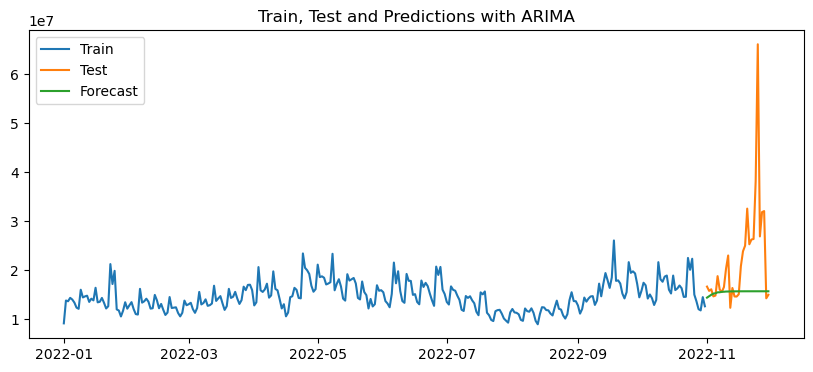

The MAE is 7267306.02
The RMSE is 12366038.30
The MAPE is 24.15 %


In [34]:
# Model assessment
model_assessment(train['y']['2022':], test['y'], predictions_arima, "ARIMA")

# SARIMA

In [35]:
# auto_arima() from pmdarima - used to automatically select the optimal parameters for an ARIMA model based on the provided time series data.
# m = The number of periods in each season.
model_sarima = auto_arima(train['y'],
                          m = 7)
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28762.051
Date:                           Wed, 29 Jan 2025   AIC                          57546.103
Time:                                   13:57:54   BIC                          57606.331
Sample:                               01-01-2018   HQIC                         57568.358
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.007e+04   4682.879      2.150      0.032     890.043    1.92e+04
ar.L1         -0.3475      0.072     -4.795      0.000      -0.490      -0.206
ar.L2          0.1856      0.032      5.721      0.000       0.122       0.249
ar.L3          0.1034      0.016      6.523      0.000       0.072       0.135
ma.L1         -0.1959      0.074     -2.656      0.008      -0.340      -0.051
ma.L2         -0.5684      0.060     -9.397      0.000      -0.687      -0.450
ar.S.L7        0.0805      0.181      0.445      0.656      -0.274       0.435
ar.S.L14       0.8713      0.172      5.068      0.000       0.534       1.208
ma.S.L7       -0.0035      0.176     -0.020      0.984      -0.349       0.342
ma.S.L14      -0.8322      0.157     -5.308      0.000      -1.139      -0.525
sigma2      9.294e+12      0.000   8.85e+16      0.000    9.29e+12    9.29e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            848681.77
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             5.24
Prob(H) (two-sided):                  0.00   Kurtosis:                       109.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.02e+30. Standard errors may be unstable.
"""

In [36]:
# Use the fitted SARIMA model to forecast future values.
# set the number of periods to forecast to the length of 'test'
predictions_sarima = model_sarima.predict(n_periods = len(test))
predictions_sarima

2022-11-01    1.513404e+07
2022-11-02    1.504532e+07
2022-11-03    1.464449e+07
2022-11-04    1.382170e+07
2022-11-05    1.397987e+07
2022-11-06    1.697861e+07
2022-11-07    1.583309e+07
2022-11-08    1.605212e+07
2022-11-09    1.575794e+07
2022-11-10    1.523577e+07
2022-11-11    1.428011e+07
2022-11-12    1.448970e+07
2022-11-13    1.761293e+07
2022-11-14    1.658417e+07
2022-11-15    1.682753e+07
2022-11-16    1.635480e+07
2022-11-17    1.582109e+07
2022-11-18    1.482087e+07
2022-11-19    1.499247e+07
2022-11-20    1.780777e+07
2022-11-21    1.673573e+07
2022-11-22    1.694584e+07
2022-11-23    1.665823e+07
2022-11-24    1.616888e+07
2022-11-25    1.526403e+07
2022-11-26    1.546992e+07
2022-11-27    1.842695e+07
2022-11-28    1.745380e+07
2022-11-29    1.769221e+07
2022-11-30    1.726668e+07
Freq: D, dtype: float64

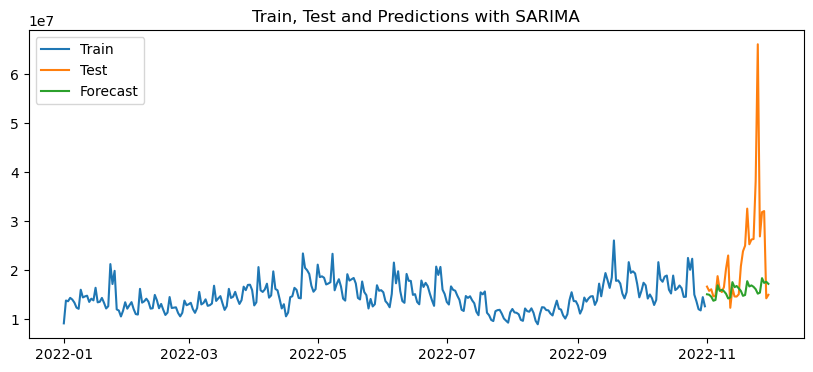

The MAE is 7210577.83
The RMSE is 12152428.23
The MAPE is 24.54 %


In [37]:
# Model assessment
model_assessment(train['y']['2022':], test['y'], predictions_sarima, "SARIMA")

* The MAE is 7267306.02
* The RMSE is 12366038.29
* The MAPE is 24.15 %

- `MAE` - the average of the absolute differences between predicted and actual values.
- `RMSE` - the square root of the average of squared differences between prediction and actual observation.
It gives a relatively high weight to large errors, making it sensitive to outliers.
- `MAPE` - the size of the error in percentage terms. the average of the absolute percent errors of forecasts, which helps to understand the accuracy in terms of percentage.

# SARIMAX

In [38]:
# Remove '%' symbol from 'discount_rate' and 'coupon_rate' column and convert to float
df['discount_rate'] = df['discount_rate'].str.replace("%", "").astype(float)
df['commuter_rate'] = df['commuter_rate'].str.replace("%", "").astype(float)

# Print the information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Freq: D
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              1795 non-null   float64
 1   discount_rate  1795 non-null   float64
 2   commuter_rate  1795 non-null   float64
 3   y_diff         1794 non-null   float64
dtypes: float64(4)
memory usage: 70.1 KB


In [39]:
# Split the Regressor Data into training and test
test_days = 30 # Number of days to reserve for testing
exog_train, exog_test = df.iloc[:-test_days,1:3], df.iloc[-test_days:,1:3]
exog_test.head()

,discount_rate,commuter_rate
date,,
2022-11-01,23.85,1.50
2022-11-02,20.76,0.94
2022-11-03,21.85,0.92
2022-11-04,20.17,0.88
2022-11-05,17.85,0.41


In [40]:
# auto_arima() from pmdarima - used to automatically select the optimal parameters for an ARIMA model based on the provided time series data.
# m = The number of periods in each season.
# X =  exogenous variables.
model_sarimax = auto_arima(train['y'],
                           m = 7,
                           X = exog_train)
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28613.022
Date:                           Wed, 29 Jan 2025   AIC                          57250.045
Time:                                   14:02:54   BIC                          57315.749
Sample:                               01-01-2018   HQIC                         57274.324
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1.641e+04   7882.252      2.082      0.037     961.790    3.19e+04
discount_rate   4.03e+05   2.35e+04     17.141      0.000    3.57e+05    4.49e+05
commuter_rate  9.229e+05   6.09e+04     15.155      0.000    8.04e+05    1.04e+06
ar.L1            -0.6526      0.156     -4.195      0.000      -0.958      -0.348
ar.L2             0.1828      0.049      3.766      0.000       0.088       0.278
ma.L1             0.1067      0.155      0.689      0.491      -0.197       0.410
ma.L2            -0.6923      0.124     -5.563      0.000      -0.936      -0.448
ar.S.L7           0.0524      0.187      0.280      0.779      -0.314       0.419
ar.S.L14          0.8998      0.178      5.063      0.000       0.552       1.248
ma.S.L7           0.0181      0.183      0.099      0.921      -0.340       0.376
ma.S.L14         -0.8500      0.161     -5.288      0.000      -1.165      -0.535
sigma2         7.655e+12      0.016    4.8e+14      0.000    7.65e+12    7.65e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1075205.67
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             5.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       123.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.24e+30. Standard errors may be unstable.
"""

In [41]:
# Use the fitted SARIMAX model to forecast future values.
# set the number of periods to forecast to the length of 'test'
# X - representing the exogenous variables for forecasting
predictions_sarimax = model_sarimax.predict(n_periods = len(test),
                                            X = exog_test)
predictions_sarimax

2022-11-01    1.675219e+07
2022-11-02    1.494566e+07
2022-11-03    1.488437e+07
2022-11-04    1.296426e+07
2022-11-05    1.205473e+07
2022-11-06    1.394981e+07
2022-11-07    1.341731e+07
2022-11-08    1.328258e+07
2022-11-09    1.441188e+07
2022-11-10    2.077603e+07
2022-11-11    2.121871e+07
2022-11-12    1.346342e+07
2022-11-13    1.489144e+07
2022-11-14    1.299958e+07
2022-11-15    1.348112e+07
2022-11-16    1.398075e+07
2022-11-17    1.803934e+07
2022-11-18    1.675141e+07
2022-11-19    1.712348e+07
2022-11-20    1.980815e+07
2022-11-21    1.847933e+07
2022-11-22    1.908260e+07
2022-11-23    1.913665e+07
2022-11-24    2.068950e+07
2022-11-25    1.926337e+07
2022-11-26    1.851313e+07
2022-11-27    2.073292e+07
2022-11-28    2.608038e+07
2022-11-29    1.588330e+07
2022-11-30    1.480001e+07
Freq: D, dtype: float64

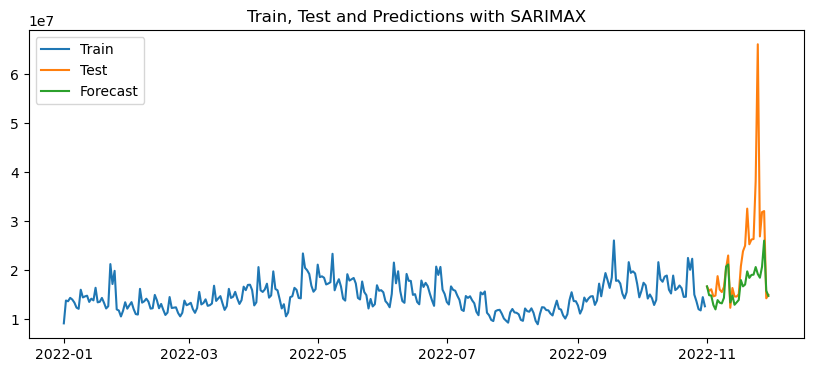

The MAE is 5716329.39
The RMSE is 10394398.38
The MAPE is 19.36 %


In [42]:
# Model assessment
model_assessment(train['y']['2022':], test['y'], predictions_sarimax, "SARIMAX")

# Cross Validation

In [43]:
# Define the model to do CV
# order = ([p] autoregressive order, [d] differencing order, [q] moving average order)
# seasonal_order = ([P] seasonal autoregressive order, [D] seasonal differencing order, [Q] seasonal moving average order, [m] number of periods per season)
model_cv = ARIMA(order = (2, 1, 2), seasonal_order = (2, 0, 2, 7))

In [44]:
# Define the rules for Rolling Forecast Cross-Validation (RollingForecastCV).
cv = model_selection.RollingForecastCV(h = 30, # forecast horizon
                                       step = 15, # moves the validation window by n time steps each iteration (every 15 days, we predict the next 30)
                                       initial = df.shape[0] - 180) # starting point for the first training set

In [45]:
# Perform cross-validation scoring using specified inputs.
cv_score = model_selection.cross_val_score(model_cv,
                                           y=df['y'],  # Target variable 'y'
                                           X=df.iloc[:, 1:3],  # Explanatory variables from columns 1 and 2
                                           scoring='mean_squared_error',  # Evaluation metric: Mean Squared Error
                                           cv=cv,  # Cross-validation strategy
                                           verbose=1,  # Verbosity level
                                           error_score=10000000000000000000000  # Value to assign if fitting error occurs
                                           )


In [46]:
# Calculate Root Mean Squared Error (RMSE) using cross-validated scores.
rmse = np.sqrt(np.average(cv_score))
print(f"The RMSE is {int(rmse)}")

The RMSE is 4405801
